# Description Model Approach 3: Fine-Tuning a Classification Model -> Predicting department

* Fine-tuned classification model. Use the csv files to fine-tune a pre-trained classification model. Apply the model to the linked-in data


In [29]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error, classification_report

from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
)

In [30]:
GH_USER = "luisadosch"
GH_REPO = "Final-Project-snapAddy"
BRANCH = "main"


def get_github_url(relative_path):
    return f"https://raw.githubusercontent.com/{GH_USER}/{GH_REPO}/{BRANCH}/{relative_path}"

In [31]:
jobs_annotated = pd.read_csv(get_github_url("data/processed/jobs_annotated.csv"))
df_department = pd.read_csv(get_github_url("data/raw/department-v2.csv"))

# test set from annotated CVs (ACTIVE only)
df_department_test = jobs_annotated.loc[jobs_annotated["status"] == "ACTIVE", ["position", "department"]].copy()
df_department_test = df_department_test.rename(columns={"position": "text", "department": "label"})

# base train/test dfs (strings)
train_df_base = df_department[["text", "label"]].copy()
test_df_base  = df_department_test[["text", "label"]].copy()


print("train:", len(train_df_base), "test:", len(test_df_base))
print("train label counts:\n", train_df_base["label"].value_counts())
print("test label counts:\n", test_df_base["label"].value_counts())

train: 10145 test: 623
train label counts:
 label
Marketing                 4295
Sales                     3328
Information Technology    1305
Business Development       620
Project Management         201
Consulting                 167
Administrative              83
Other                       42
Purchasing                  40
Customer Support            33
Human Resources             31
Name: count, dtype: int64
test label counts:
 label
Other                     344
Information Technology     62
Sales                      46
Consulting                 39
Project Management         39
Marketing                  22
Business Development       20
Human Resources            16
Purchasing                 15
Administrative             14
Customer Support            6
Name: count, dtype: int64


In [32]:
def add_synthetic_department(train_df: pd.DataFrame, synthetic_csv_relpath: str) -> pd.DataFrame:
    syn = pd.read_csv(get_github_url(synthetic_csv_relpath))

    # expect columns: position, department
    syn = syn[["position", "department"]].copy()
    syn = syn.rename(columns={"position": "text", "department": "label"})
    syn = syn.dropna(subset=["text", "label"])

    out = pd.concat([train_df[["text", "label"]], syn[["text", "label"]]], ignore_index=True)
    return out


In [33]:
MODEL_CKPT = "xlm-roberta-base"
MAX_LEN = 80

tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LEN,
    )

In [34]:
def to_hf_dataset(df: pd.DataFrame, label_col: str = "labels") -> Dataset:
    ds = Dataset.from_pandas(df[["text", label_col]].copy(), preserve_index=False)
    ds = ds.map(tokenize, batched=True)
    ds.set_format(type="torch", columns=["input_ids", "attention_mask", label_col])
    return ds

In [35]:
def eval_split(trainer, train_ds, val_ds, test_ds):
    train_metrics = trainer.evaluate(train_ds, metric_key_prefix="train")
    val_metrics   = trainer.evaluate(val_ds,   metric_key_prefix="val")
    test_metrics  = trainer.evaluate(test_ds,  metric_key_prefix="test")
    print("Evaluation based on training data:", train_metrics)
    print("Evaluation based on val data:  ", val_metrics)
    print("Evaluation based on test data: ", test_metrics)
    return train_metrics, val_metrics, test_metrics

In [36]:
def loss_curves(trainer):
    logs = pd.DataFrame(trainer.state.log_history)

    train_loss = logs.dropna(subset=["loss"])[["step", "loss"]].copy()
    eval_loss  = logs.dropna(subset=["eval_loss"])[["step", "eval_loss"]].copy()

    import matplotlib.pyplot as plt

    plt.figure()
    plt.plot(train_loss["step"], train_loss["loss"])
    plt.xlabel("step")
    plt.ylabel("train loss")
    plt.title("Train loss")
    plt.show()

    plt.figure()
    plt.plot(eval_loss["step"], eval_loss["eval_loss"])
    plt.xlabel("step")
    plt.ylabel("eval loss")
    plt.title("Eval loss")
    plt.show()

    return logs

classification pipeline

In [37]:
def compute_metrics_cls(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
    }

In [38]:
def predict_table_cls(trainer, ds, df_text_label, id2label):
    pred = trainer.predict(ds)
    probs = pred.predictions
    y_pred = np.argmax(probs, axis=-1)

    out = df_text_label.copy().reset_index(drop=True)
    out["pred_id"] = y_pred
    out["pred_label"] = [id2label[int(i)] for i in y_pred]
    out["correct"] = (out["pred_label"] == out["label"])
    return out

In [39]:
def report_cls(trainer, ds, id2label):
    pred = trainer.predict(ds)
    y_pred = np.argmax(pred.predictions, axis=-1)
    y_true = pred.label_ids
    print(classification_report(y_true, y_pred, target_names=[id2label[i] for i in range(len(id2label))]))

In [40]:
from sklearn.utils import resample
def oversample_df(df, label_col="label", random_state=42):
    max_n = df[label_col].value_counts().max()
    parts = []
    for lab, g in df.groupby(label_col):
        parts.append(resample(g, replace=True, n_samples=max_n, random_state=random_state))
    return pd.concat(parts).sample(frac=1, random_state=random_state).reset_index(drop=True)

def run_classification(train_df, test_df, out_dir="dept_cls",
                       do_oversample=False, random_state=42):
    # label space ONLY from train_df (no leakage)
    label_list = sorted(train_df["label"].unique())
    label2id = {l: i for i, l in enumerate(label_list)}
    id2label = {i: l for l, i in label2id.items()}

    tr = train_df.copy()
    te = test_df.copy()

    tr["labels"] = tr["label"].map(label2id).astype(int)
    te["labels"] = te["label"].map(label2id)

    print("labels:", label_list)
    print("test missing labels:", int(te["labels"].isna().sum()))

    # IMPORTANT: drop test rows with unseen labels (otherwise crashes)
    te = te.dropna(subset=["labels"]).copy()
    te["labels"] = te["labels"].astype(int)


    train_sub, val = train_test_split(
        tr, test_size=0.2, stratify=tr["label"], random_state=42
        )


    train_for_fit = oversample_df(train_sub, label_col="label", random_state=random_state) if do_oversample else train_sub

    train_ds = to_hf_dataset(train_for_fit, label_col="labels")
    val_ds   = to_hf_dataset(val,          label_col="labels")
    test_ds  = to_hf_dataset(te,           label_col="labels")

    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_CKPT,
        num_labels=len(label2id),
        id2label=id2label,
        label2id=label2id,
    )

    # CHANGE HERE for hyperparams / logging / epochs:
    args = TrainingArguments(
        output_dir=out_dir,
        learning_rate=1e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        num_train_epochs=10,
        weight_decay=0.05,
        warmup_ratio=0.06,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1_macro",
        greater_is_better=True,
        fp16=True,
        report_to="none",
        dataloader_num_workers=0,
        logging_strategy="steps",
        logging_steps=50,
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics_cls,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    )

    trainer.train()

    eval_split(trainer, train_ds, val_ds, test_ds)
    loss_curves(trainer)

    train_pred = predict_table_cls(trainer, train_ds, train_for_fit[["text", "label"]], id2label)
    val_pred   = predict_table_cls(trainer, val_ds,   val[["text", "label"]], id2label)
    test_pred  = predict_table_cls(trainer, test_ds,  te[["text", "label"]], id2label)

    display(test_pred.head(30))
    report_cls(trainer, val_ds, id2label)

    return trainer, (train_pred, val_pred, test_pred), (label2id, id2label)

model runs

classification without synth. data

In [41]:
import torch
print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())
print("cuda device count:", torch.cuda.device_count())
print("current device:", torch.cuda.current_device() if torch.cuda.is_available() else None)
print("gpu name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else None)

torch: 2.9.0+cu126
cuda available: True
cuda device count: 1
current device: 0
gpu name: Tesla T4


classification with synthetic data

1) Normal (no synthetic, no oversampling)

labels: ['Administrative', 'Business Development', 'Consulting', 'Customer Support', 'Human Resources', 'Information Technology', 'Marketing', 'Other', 'Project Management', 'Purchasing', 'Sales']
test missing labels: 0


Map:   0%|          | 0/8116 [00:00<?, ? examples/s]

Map:   0%|          | 0/2029 [00:00<?, ? examples/s]

Map:   0%|          | 0/623 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1032859879.py:69: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.302300,0.205586,0.949236,0.414198
2,0.101100,0.090269,0.982750,0.768428
3,0.088200,0.071995,0.987186,0.913077
4,0.065100,0.051777,0.992114,0.953487
5,0.021900,0.037499,0.995564,0.985578
6,0.028200,0.038512,0.994579,0.984295
7,0.017100,0.038024,0.995071,0.979640


early stopping required metric_for_best_model, but did not find eval_f1_macro so early stopping is disabled
early stopping required metric_for_best_model, but did not find eval_f1_macro so early stopping is disabled
early stopping required metric_for_best_model, but did not find eval_f1_macro so early stopping is disabled


Evaluation based on training data: {'train_loss': 0.011978618800640106, 'train_accuracy': 0.9983982257269591, 'train_f1_macro': 0.995247810577619, 'train_runtime': 5.6781, 'train_samples_per_second': 1429.361, 'train_steps_per_second': 44.734, 'epoch': 7.0}
Evaluation based on val data:   {'val_loss': 0.037498585879802704, 'val_accuracy': 0.9955643173977329, 'val_f1_macro': 0.9855781456771218, 'val_runtime': 1.4413, 'val_samples_per_second': 1407.773, 'val_steps_per_second': 44.405, 'epoch': 7.0}
Evaluation based on test data:  {'test_loss': 3.96114444732666, 'test_accuracy': 0.3258426966292135, 'test_f1_macro': 0.42404252914890145, 'test_runtime': 0.4578, 'test_samples_per_second': 1360.857, 'test_steps_per_second': 43.687, 'epoch': 7.0}


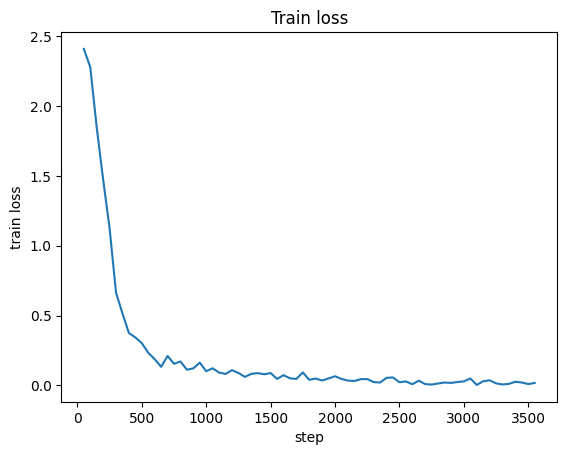

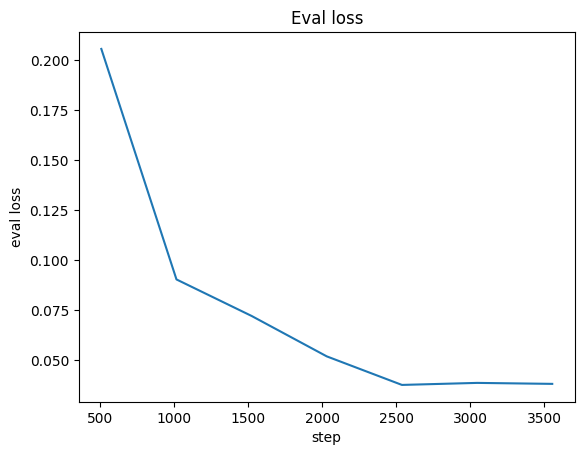

,text,label,pred_id,pred_label,correct
0,Prokurist,Other,5,Information Technology,False
1,CFO,Other,5,Information Technology,False
2,Betriebswirtin,Other,9,Purchasing,False
3,Prokuristin,Other,5,Information Technology,False
4,CFO,Other,5,Information Technology,False
5,Solutions Architect,Information Technology,5,Information Technology,True
6,Medizintechnik Beratung,Consulting,5,Information Technology,False
7,Director expansión de negocio.,Business Development,1,Business Development,True
8,Gerente comercial,Sales,6,Marketing,False
9,Administrador Unico,Administrative,5,Information Technology,False


                        precision    recall  f1-score   support

        Administrative       1.00      0.94      0.97        17
  Business Development       0.99      1.00      1.00       124
            Consulting       1.00      0.97      0.98        33
      Customer Support       1.00      1.00      1.00         7
       Human Resources       1.00      1.00      1.00         6
Information Technology       0.98      0.99      0.99       261
             Marketing       1.00      1.00      1.00       859
                 Other       1.00      1.00      1.00         8
    Project Management       1.00      0.95      0.97        40
            Purchasing       1.00      0.88      0.93         8
                 Sales       1.00      1.00      1.00       666

              accuracy                           1.00      2029
             macro avg       1.00      0.97      0.99      2029
          weighted avg       1.00      1.00      1.00      2029



In [42]:
dept_trainer_base, dept_preds_base, dept_maps_base = run_classification(
    train_df_base, test_df_base,
    out_dir="department_cls_base",
    do_oversample=False
)


2) No synthetic + oversampling

labels: ['Administrative', 'Business Development', 'Consulting', 'Customer Support', 'Human Resources', 'Information Technology', 'Marketing', 'Other', 'Project Management', 'Purchasing', 'Sales']
test missing labels: 0


Map:   0%|          | 0/37796 [00:00<?, ? examples/s]

Map:   0%|          | 0/2029 [00:00<?, ? examples/s]

Map:   0%|          | 0/623 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1032859879.py:69: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.021500,0.037092,0.994086,0.984140
2,0.006600,0.044746,0.994086,0.987309
3,0.015100,0.030223,0.996057,0.983894
4,0.010400,0.036834,0.996057,0.988335
5,0.000000,0.036564,0.996550,0.988771
6,0.000000,0.040228,0.996550,0.998050
7,0.000000,0.037377,0.997043,0.995746
8,0.000000,0.042810,0.996057,0.993948


early stopping required metric_for_best_model, but did not find eval_f1_macro so early stopping is disabled
early stopping required metric_for_best_model, but did not find eval_f1_macro so early stopping is disabled
early stopping required metric_for_best_model, but did not find eval_f1_macro so early stopping is disabled


Evaluation based on training data: {'train_loss': 0.002635982818901539, 'train_accuracy': 0.999603132606625, 'train_f1_macro': 0.9996031323629812, 'train_runtime': 25.4053, 'train_samples_per_second': 1487.724, 'train_steps_per_second': 46.526, 'epoch': 8.0}
Evaluation based on val data:   {'val_loss': 0.04022834077477455, 'val_accuracy': 0.9965500246426812, 'val_f1_macro': 0.9980502667569862, 'val_runtime': 1.4451, 'val_samples_per_second': 1404.034, 'val_steps_per_second': 44.287, 'epoch': 8.0}
Evaluation based on test data:  {'test_loss': 6.534465789794922, 'test_accuracy': 0.3017656500802568, 'test_f1_macro': 0.4318110250242617, 'test_runtime': 0.4464, 'test_samples_per_second': 1395.695, 'test_steps_per_second': 44.806, 'epoch': 8.0}


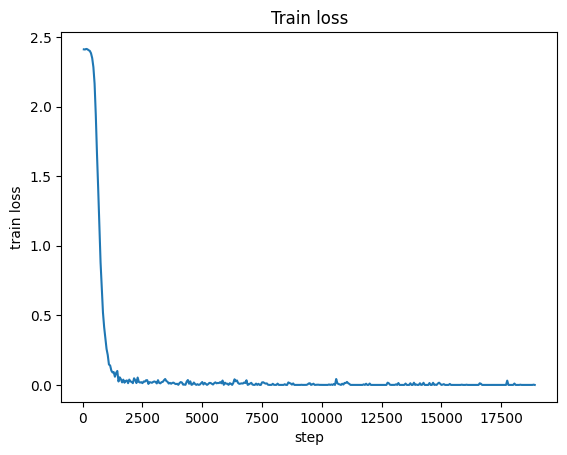

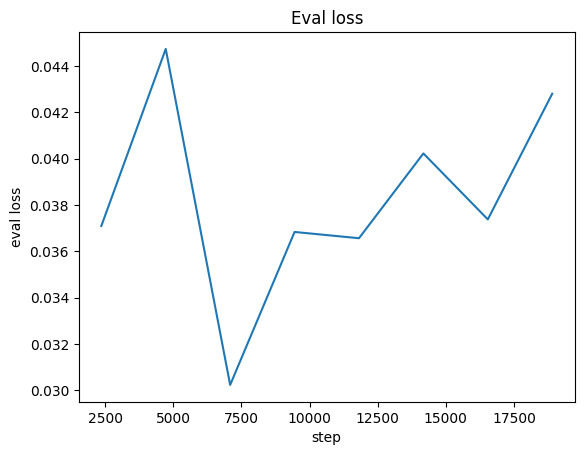

,text,label,pred_id,pred_label,correct
0,Prokurist,Other,10,Sales,False
1,CFO,Other,5,Information Technology,False
2,Betriebswirtin,Other,7,Other,True
3,Prokuristin,Other,5,Information Technology,False
4,CFO,Other,5,Information Technology,False
5,Solutions Architect,Information Technology,8,Project Management,False
6,Medizintechnik Beratung,Consulting,5,Information Technology,False
7,Director expansión de negocio.,Business Development,1,Business Development,True
8,Gerente comercial,Sales,0,Administrative,False
9,Administrador Unico,Administrative,5,Information Technology,False


                        precision    recall  f1-score   support

        Administrative       1.00      1.00      1.00        17
  Business Development       0.99      0.99      0.99       124
            Consulting       1.00      1.00      1.00        33
      Customer Support       1.00      1.00      1.00         7
       Human Resources       1.00      1.00      1.00         6
Information Technology       1.00      0.98      0.99       261
             Marketing       1.00      1.00      1.00       859
                 Other       1.00      1.00      1.00         8
    Project Management       1.00      1.00      1.00        40
            Purchasing       1.00      1.00      1.00         8
                 Sales       0.99      1.00      1.00       666

              accuracy                           1.00      2029
             macro avg       1.00      1.00      1.00      2029
          weighted avg       1.00      1.00      1.00      2029



In [43]:
dept_trainer_os, dept_preds_os, dept_maps_os = run_classification(
    train_df_base, test_df_base,
    out_dir="department_cls_oversample",
    do_oversample=True
)


## 3) With synthetic

labels: ['Administrative', 'Business Development', 'Consulting', 'Customer Support', 'Human Resources', 'Information Technology', 'Marketing', 'Other', 'Project Management', 'Purchasing', 'Sales']
test missing labels: 0


Map:   0%|          | 0/8916 [00:00<?, ? examples/s]

Map:   0%|          | 0/2229 [00:00<?, ? examples/s]

Map:   0%|          | 0/623 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1032859879.py:69: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.435500,0.365608,0.903096,0.439924
2,0.213100,0.233774,0.945267,0.682610
3,0.153600,0.181201,0.962315,0.862283
4,0.112200,0.176662,0.965904,0.877822
5,0.076900,0.171027,0.971288,0.905126
6,0.086300,0.168450,0.970839,0.894697
7,0.038100,0.175159,0.971736,0.900115


early stopping required metric_for_best_model, but did not find eval_f1_macro so early stopping is disabled
early stopping required metric_for_best_model, but did not find eval_f1_macro so early stopping is disabled
early stopping required metric_for_best_model, but did not find eval_f1_macro so early stopping is disabled


Evaluation based on training data: {'train_loss': 0.05580412596464157, 'train_accuracy': 0.9882234185733513, 'train_f1_macro': 0.9517603555914019, 'train_runtime': 6.1701, 'train_samples_per_second': 1445.024, 'train_steps_per_second': 45.218, 'epoch': 7.0}
Evaluation based on val data:   {'val_loss': 0.1710265576839447, 'val_accuracy': 0.9712875729026469, 'val_f1_macro': 0.9051258794132585, 'val_runtime': 1.5828, 'val_samples_per_second': 1408.301, 'val_steps_per_second': 44.227, 'epoch': 7.0}
Evaluation based on test data:  {'test_loss': 1.9963452816009521, 'test_accuracy': 0.6565008025682183, 'test_f1_macro': 0.6204698289634855, 'test_runtime': 0.4519, 'test_samples_per_second': 1378.52, 'test_steps_per_second': 44.254, 'epoch': 7.0}


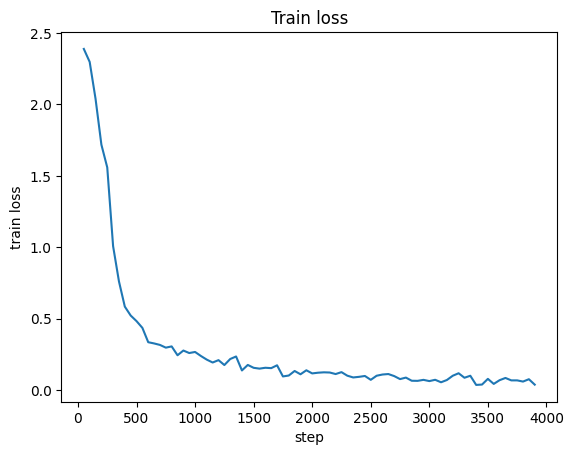

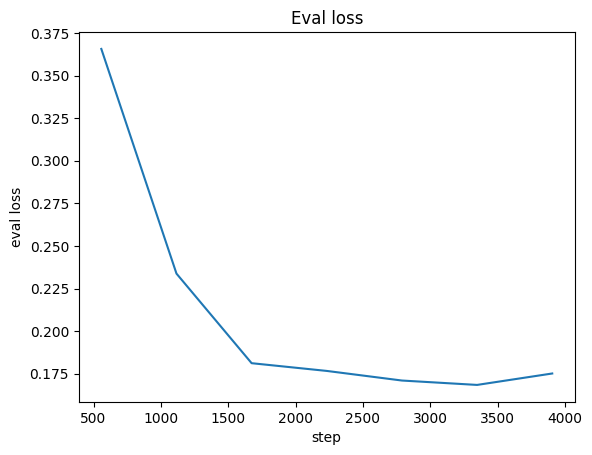

,text,label,pred_id,pred_label,correct
0,Prokurist,Other,0,Administrative,False
1,CFO,Other,7,Other,True
2,Betriebswirtin,Other,7,Other,True
3,Prokuristin,Other,7,Other,True
4,CFO,Other,7,Other,True
5,Solutions Architect,Information Technology,5,Information Technology,True
6,Medizintechnik Beratung,Consulting,5,Information Technology,False
7,Director expansión de negocio.,Business Development,1,Business Development,True
8,Gerente comercial,Sales,10,Sales,True
9,Administrador Unico,Administrative,0,Administrative,True


                        precision    recall  f1-score   support

        Administrative       0.88      0.82      0.85        28
  Business Development       0.94      0.97      0.95       140
            Consulting       0.92      0.94      0.93        50
      Customer Support       0.80      0.73      0.76        11
       Human Resources       1.00      0.73      0.85        15
Information Technology       0.95      0.95      0.95       281
             Marketing       0.99      1.00      0.99       869
                 Other       0.91      0.79      0.85        87
    Project Management       0.92      0.91      0.92        54
            Purchasing       1.00      0.85      0.92        13
                 Sales       0.98      1.00      0.99       681

              accuracy                           0.97      2229
             macro avg       0.94      0.88      0.91      2229
          weighted avg       0.97      0.97      0.97      2229



In [46]:
train_df_aug = add_synthetic_department(train_df_base, "data/results/gemini_synthetic.csv")  # example path

dept_trainer_syn, dept_preds_syn, dept_maps_syn = run_classification(
    train_df_aug, test_df_base,
    out_dir="department_cls_synth",
    do_oversample=False
)
